competition here https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/overview


In [1]:
#!pip install optuna -q

In [2]:
import pandas as pd
import numpy as np
import os
#import json
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
#import phik
#from scipy.stats import kstest

from sklearn.model_selection import train_test_split, GroupShuffleSplit
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [3]:
#константы
STATE = 33443

#Путь к каталогу с данными
DATA_PATH = 'linking_writing/'
DATA_PATH_GOOGLE = '/content/drive/MyDrive/Peton/Kaggle_linking_writing/'

DATA_PATH = '/kaggle/input/linking-writing-processes-to-writing-quality/'
DATA_PATH_GOOGLE = '/kaggle/input/linking-writing-processes-to-writing-quality/'

## read all data

In [4]:
#прочитаем данные sample_submission
patch = os.path.join(DATA_PATH, 'sample_submission.csv')

sample_submission = pd.read_csv(patch)
sample_submission.head()

,id,score
0,0000aaaa,1.0
1,2222bbbb,2.0
2,4444cccc,3.0


In [5]:
#прочитаем данные test_logs
patch = os.path.join(DATA_PATH, 'test_logs.csv')

test_logs = pd.read_csv(patch)
test_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0


In [6]:
#прочитаем данные train_logs
patch = os.path.join(DATA_PATH, 'train_logs.csv')

train_logs = pd.read_csv(patch)
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [7]:
#прочитаем данные train_scores
patch = os.path.join(DATA_PATH, 'train_scores.csv')

train_scores = pd.read_csv(patch)
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


## Issue of data

In [8]:
train_logs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int64 
 2   down_time        int64 
 3   up_time          int64 
 4   action_time      int64 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int64 
 10  word_count       int64 
dtypes: int64(6), object(5)
memory usage: 2.8 GB


In [9]:
train_logs.isna().sum()

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
dtype: int64

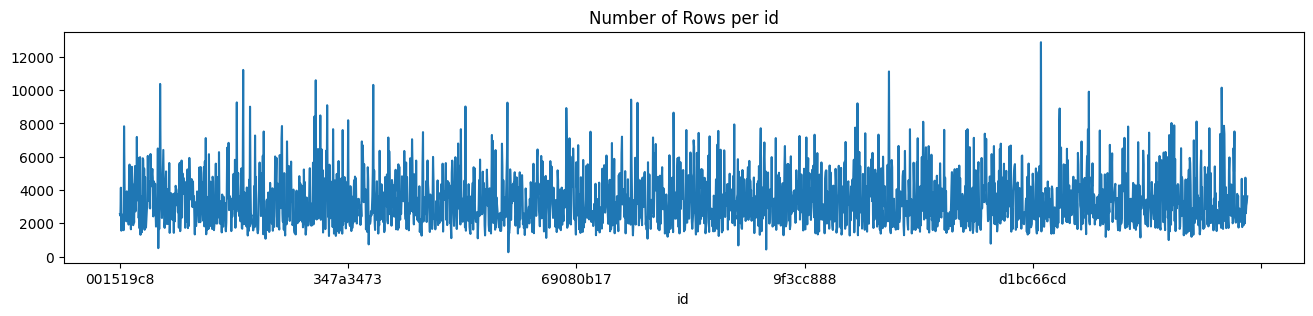

In [10]:
#количество строк по каждому id
#Plot the number of rows per id
train_logs_groupby = train_logs.groupby('id').size()
train_logs_groupby.plot(title='Number of Rows per id', figsize=(16, 3), xlabel='id');

In [11]:
train_logs_groupby.min(), train_logs_groupby.max()

(262, 12876)

In [12]:
#поиск пользователя с огромным количеством правок
train_logs_groupby[train_logs_groupby > 12000]

id
d3fef198    12876
dtype: int64

In [13]:
#проверка что кол-во таргетов совпадает с количеством id
train_logs_groupby.shape, train_scores.shape

((2471,), (2471, 2))

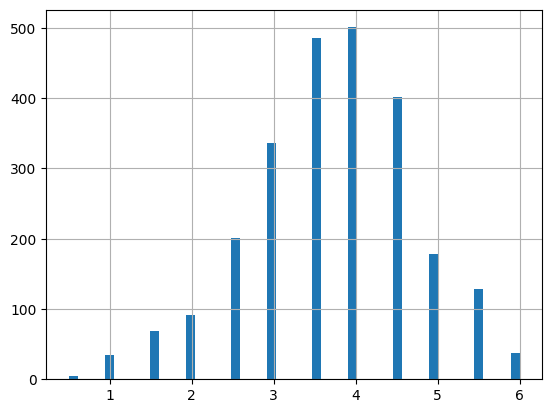

In [14]:
train_scores['score'].hist(bins=50);

In [15]:
train_scores['score'].value_counts()

score
4.0    501
3.5    486
4.5    402
3.0    336
2.5    201
5.0    179
5.5    128
2.0     92
1.5     69
6.0     37
1.0     35
0.5      5
Name: count, dtype: int64

In [16]:
train_scores['score'].nunique()

12

In [17]:

#for user 'd3fef198'
user_d3fef198 = train_logs.loc[train_logs['id'] == 'd3fef198']
user_d3fef198

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
6857805,d3fef198,1,844,1061,217,Nonproduction,Leftclick,Leftclick,NoChange,0,0
6857806,d3fef198,2,6951,7172,221,Nonproduction,Leftclick,Leftclick,NoChange,0,0
6857807,d3fef198,3,28631,28631,0,Nonproduction,Shift,Shift,NoChange,0,0
6857808,d3fef198,4,28706,28796,90,Input,q,q,q,1,1
6857809,d3fef198,5,28753,28865,112,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
6870676,d3fef198,12872,1814664,1814729,65,Input,.,.,.,5480,954
6870677,d3fef198,12873,1814942,1814981,39,Remove/Cut,Backspace,Backspace,.,5479,954
6870678,d3fef198,12874,1815034,1815094,60,Remove/Cut,Backspace,Backspace,",",5478,954
6870679,d3fef198,12875,1815273,1815306,33,Input,.,.,.,5479,954


In [18]:
user_d3fef198['activity'].value_counts()

activity
Input            9091
Remove/Cut       3370
Nonproduction     414
Replace             1
Name: count, dtype: int64

In [19]:

user_d3fef198['text_change'].value_counts()

text_change
q                                                                             10067
                                                                               2011
NoChange                                                                        414
,                                                                               120
.                                                                                70
=                                                                                26
)                                                                                25
;                                                                                24
-                                                                                24
\n                                                                               21
?                                                                                12
'                                                               

In [20]:
#кол-во дубликатов строк
train_logs.duplicated().sum()

0

In [21]:
#for user '001519c8'
user_001519c8 = train_logs.loc[train_logs['id'] == '001519c8']
user_001519c8

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
2552,001519c8,2553,1781786,1781841,55,Remove/Cut,Backspace,Backspace,q,555,255
2553,001519c8,2554,1781917,1781991,74,Remove/Cut,Backspace,Backspace,q,554,255
2554,001519c8,2555,1782062,1782141,79,Remove/Cut,Backspace,Backspace,q,553,255
2555,001519c8,2556,1782922,1782985,63,Input,q,q,q,554,255


In [22]:
1781841 - 1781786

55

In [23]:
user_001519c8['activity'].value_counts()

activity
Input                                 2010
Remove/Cut                             417
Nonproduction                          120
Replace                                  7
Move From [284, 292] To [282, 290]       1
Move From [287, 289] To [285, 287]       1
Move From [460, 461] To [465, 466]       1
Name: count, dtype: int64

In [24]:
train_logs['activity'].nunique()

50

In [25]:
train_logs['activity'].value_counts()

activity
Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [13, 65] To [9, 61]                   1
Move From [274, 314] To [299, 339]              1
Move From [624, 625] To [845, 846]              1
Move From [1861, 2063] To [1766, 1968]          1
Move From [1766, 1968] To [1861, 2063]          1
Move From [2091, 2179] To [252, 340]            1
Move From [923, 1077] To [340, 494]             1
Move From [0, 1] To [590, 591]                  1
Move From [999, 1000] To [1000, 1001]           1
Move From [0, 75] To [1, 76]                    1
Move From [1651, 1769] To [1565, 1683]          1
Move From [61, 136] To [0, 75]                  1
Move From [623, 632] To [624, 633]              1
Move From [75, 134] To [304, 363]        

In [26]:
user_001519c8['down_event'].value_counts()

down_event
q             1619
Backspace      417
Space          357
Leftclick       92
Shift           27
.               21
,               12
Enter            4
'                3
ArrowLeft        2
ArrowRight       2
;                1
Name: count, dtype: int64

In [27]:
user_001519c8['up_event'].value_counts()

up_event
q             1619
Backspace      417
Space          357
Leftclick       92
Shift           27
.               21
,               12
Enter            4
'                3
ArrowLeft        2
ArrowRight       2
;                1
Name: count, dtype: int64

In [28]:
#проверка для одного айди что данные одинаковы для столбцов `down_event` `up_event`
(user_001519c8['down_event'] == user_001519c8['up_event']).min()

True

In [29]:
#проверка для всего датасета что данные одинаковы для столбцов  `down_event` `up_event`
(train_logs['down_event'] == train_logs['up_event']).mean()

0.999936473176334

значит есть где-то неодинаковые данные и интересно что в 99.9936 % случаев данные одинаковы !

In [30]:
#text_change
train_logs['text_change'].value_counts()

text_change
q                                                                                                                                                               6128208
                                                                                                                                                                1376829
NoChange                                                                                                                                                         703851
.                                                                                                                                                                 67797
,                                                                                                                                                                 54797
                                                                                                                                                    

In [31]:
train_logs['action_time'].describe()

count    8.405898e+06
mean     9.808498e+01
std      2.533985e+02
min      0.000000e+00
25%      6.600000e+01
50%      9.300000e+01
75%      1.220000e+02
max      4.474700e+05
Name: action_time, dtype: float64

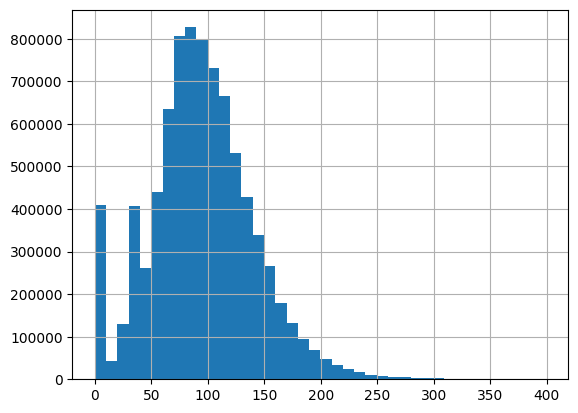

In [32]:
#action_time
train_logs.loc[train_logs['action_time'] < 4e2]['action_time'].hist(bins=40);

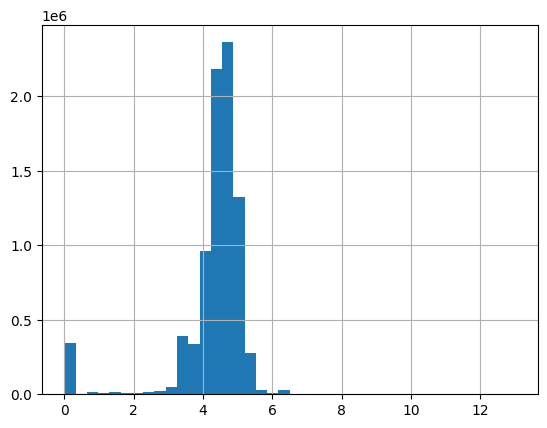

In [33]:
#log action_time
np.log1p(train_logs['action_time']).hist(bins=40);

In [34]:
train_logs.loc[train_logs['action_time'] > 1e3].count()

id                 5787
event_id           5787
down_time          5787
up_time            5787
action_time        5787
activity           5787
down_event         5787
up_event           5787
text_change        5787
cursor_position    5787
word_count         5787
dtype: int64

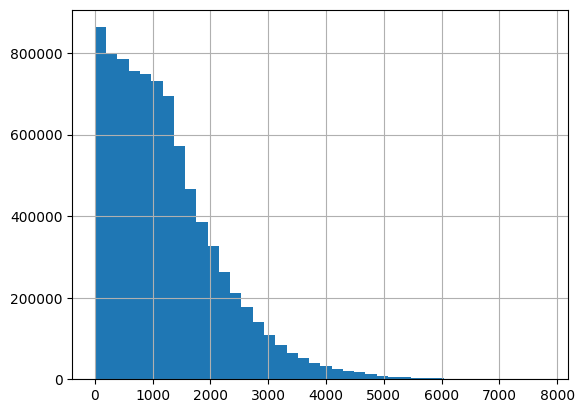

In [35]:
#cursor_position
train_logs['cursor_position'].hist(bins=40);

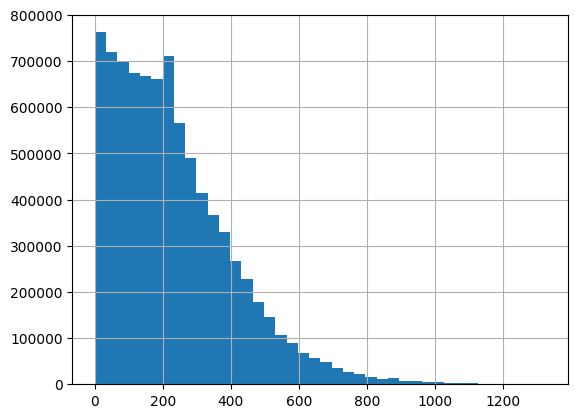

In [36]:
#word_count
train_logs['word_count'].hist(bins=40);

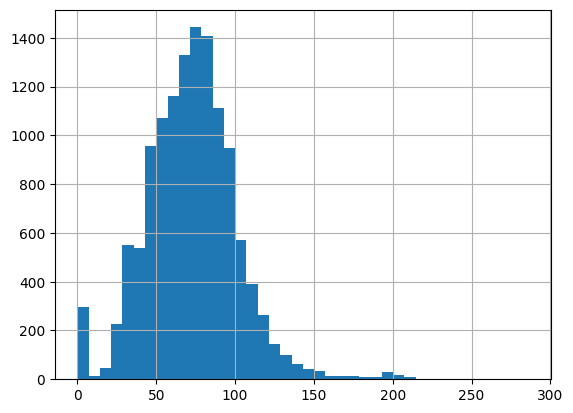

In [37]:
#action_time
user_d3fef198.loc[user_d3fef198['action_time'] < 300]['action_time'].hist(bins=40);

In [38]:
user_d3fef198

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
6857805,d3fef198,1,844,1061,217,Nonproduction,Leftclick,Leftclick,NoChange,0,0
6857806,d3fef198,2,6951,7172,221,Nonproduction,Leftclick,Leftclick,NoChange,0,0
6857807,d3fef198,3,28631,28631,0,Nonproduction,Shift,Shift,NoChange,0,0
6857808,d3fef198,4,28706,28796,90,Input,q,q,q,1,1
6857809,d3fef198,5,28753,28865,112,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
6870676,d3fef198,12872,1814664,1814729,65,Input,.,.,.,5480,954
6870677,d3fef198,12873,1814942,1814981,39,Remove/Cut,Backspace,Backspace,.,5479,954
6870678,d3fef198,12874,1815034,1815094,60,Remove/Cut,Backspace,Backspace,",",5478,954
6870679,d3fef198,12875,1815273,1815306,33,Input,.,.,.,5479,954


Идеи:

0. удалить столбец `up_event`, потому что он в 99,99% случаев повторяет столбец `down_event`.
1. для каждого юзера собрать статистику
- колчество записей (правок)
- посчитать кол-во каждого вида `activity`
-

2. подумать о логарифмировании некоторых столбцов
3. посчитать лаг по `down_time`, потом на его основе посчитать разные статистики

4. может посмотреть некий график по времени `down_time` для некоторых клиентов? Может `cursor_position` или ещё что
5.

-- --
Ideas:

0. remove the `up_event` column, because in 99.99% of cases it is the same as the `down_event` column.
1. collect statistics for each user
- number of entries (edits)
- count the number of each type of `activity`
-

2. think about taking logarithms of some columns
3. calculate the lag using `down_time`, then calculate various statistics based on it

4. Can I look at a certain `down_time` time graph for some clients? Maybe `cursor_position` or something else
5.

## Test

In [39]:
test_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               6 non-null      object
 1   event_id         6 non-null      int64 
 2   down_time        6 non-null      int64 
 3   up_time          6 non-null      int64 
 4   action_time      6 non-null      int64 
 5   activity         6 non-null      object
 6   down_event       6 non-null      object
 7   up_event         6 non-null      object
 8   text_change      6 non-null      object
 9   cursor_position  6 non-null      int64 
 10  word_count       6 non-null      int64 
dtypes: int64(6), object(5)
memory usage: 656.0+ bytes


## Prepare data

### Использование разделителя данных с учетом групп (по id)
### Separate data by id
> Indented blockz




In [40]:
train_logs.shape, train_scores.shape

((8405898, 11), (2471, 2))

In [41]:
train_id, valid_id = train_test_split(train_scores['id'], test_size=0.2, random_state = STATE)
train_id.shape, valid_id.shape

((1976,), (495,))

In [42]:
x_train = train_logs.loc[train_logs['id'].isin(train_id)]
y_train = train_scores.loc[train_scores['id'].isin(train_id)]

x_valid = train_logs.loc[train_logs['id'].isin(valid_id)]
y_valid = train_scores.loc[train_scores['id'].isin(valid_id)]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape


((6707106, 11), (1976, 2), (1698792, 11), (495, 2))

In [43]:
#check
x_train.shape[0] + x_valid.shape[0] == train_logs.shape[0]

True

In [44]:
#проверка что ни один id не встречается в двух выборках одновременно
#check
x_train.id.isin(x_valid.id).sum()

0

In [45]:
#train_logs.groupby('id').agg({'text_change': list}).reset_index()

### add new future

In [46]:
x_train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [47]:
#удаление лишнего столбца
def del_coll(df):
    return df.drop(['event_id', 'up_event'], axis=1)

In [48]:
#log coll 'action_time'
def action_time_log(df):
    df['action_time_log'] = np.log1p(df['action_time'])
    return df

In [49]:
#lag for 'down_time'
def shift_coll(df):
    df['down_time_lag1'] = df['down_time'].shift(1).fillna(0)
    return df

In [50]:
'''
Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [13, 65] To [9, 61]                   1
Move From [274, 314] To [299, 339]              1
Move From [624, 625] To [845, 846]              1

#добавление признаков по столбцу activity для каждого пользователя
def add_activity(df):
    df.groupby('id')['activity']
'''

"\nInput                                     6726796\nRemove/Cut                                 970158\nNonproduction                              703851\nReplace                                      4448\nPaste                                         599\nMove From [1306, 1371] To [1061, 1126]          2\nMove From [13, 65] To [9, 61]                   1\nMove From [274, 314] To [299, 339]              1\nMove From [624, 625] To [845, 846]              1\n\n#добавление признаков по столбцу activity для каждого пользователя\ndef add_activity(df):\n    df.groupby('id')['activity']\n"

In [51]:
#уникальные названия столбцов для дальнейшей работы
train_logs['activity'].unique()

array(['Nonproduction', 'Input', 'Remove/Cut', 'Replace',
       'Move From [284, 292] To [282, 290]',
       'Move From [287, 289] To [285, 287]',
       'Move From [460, 461] To [465, 466]', 'Paste',
       'Move From [905, 1314] To [907, 1316]',
       'Move From [565, 743] To [669, 847]',
       'Move From [669, 847] To [565, 743]',
       'Move From [1041, 1121] To [1496, 1576]',
       'Move From [1455, 1557] To [1323, 1425]',
       'Move From [2268, 2275] To [2247, 2254]',
       'Move From [213, 302] To [902, 991]',
       'Move From [0, 158] To [234, 392]',
       'Move From [460, 465] To [925, 930]',
       'Move From [810, 906] To [816, 912]',
       'Move From [186, 187] To [184, 185]',
       'Move From [140, 272] To [299, 431]',
       'Move From [114, 140] To [272, 298]',
       'Move From [1386, 1450] To [1445, 1509]',
       'Move From [442, 524] To [296, 378]',
       'Move From [408, 414] To [390, 396]',
       'Move From [1144, 1147] To [1142, 1145]',
       'Move 

In [52]:
columns_activity = ['Nonproduction', 'Input', 'Remove/Cut', 'Replace', 'Move']

In [53]:
#создание нового датасета. В него войдёт id и аггрегации по некоторым столбцам
def new_df(df):
    df = df.groupby(['id'], as_index=True).agg({'action_time':['mean', 'std'],
                                                'word_count':['mean', 'std'],
                                                'action_time_log':['mean', 'std'],
                                                'down_time_lag1':['mean', 'std'],
                                                })
    df.columns = ['_'.join(col) for col in df.columns]
    df = df.reset_index()
    return df

In [54]:
#x_train_new = new_df(x_train)
#x_train_new

Добавление в датасет признаков

In [55]:
pipe_add = Pipeline([('del_coll', FunctionTransformer(del_coll, validate=False)),
                     ('action_time_log', FunctionTransformer(action_time_log, validate=False)),
                     ('shift_coll', FunctionTransformer(shift_coll, validate=False)),
                     ('new_df', FunctionTransformer(new_df, validate=False))
                     ])

In [56]:
x_train_new = pipe_add.transform(x_train)

In [57]:
x_train_new.head(10)

,id,action_time_mean,action_time_std,word_count_mean,word_count_std,action_time_log_mean,action_time_log_std,down_time_lag1_mean,down_time_lag1_std
0,001519c8,116.246774,91.797374,128.116152,76.498372,4.599037,0.731816,847476.087994,395017.895651
1,0059420b,121.848329,113.768226,103.618895,61.882250,4.112479,1.670000,785738.478149,385747.129680
2,0075873a,123.943896,62.082013,125.082971,77.255054,4.631532,0.835734,713252.263137,405370.160405
3,0081af50,81.404342,40.653054,132.942560,81.208824,4.324892,0.491386,544286.520579,484522.665101
4,0093f095,109.717847,37.018331,119.671388,72.388234,4.617338,0.585590,354320.565439,242084.043765
5,009e23ab,90.755631,41.934952,154.297068,93.486783,4.342355,0.870865,487653.051424,279532.402824
6,00e048f1,75.011356,33.244615,114.762776,66.917911,4.213029,0.667777,837618.558360,345751.468740
7,00e713bd,94.306900,47.010933,274.463527,167.907921,4.438922,0.647760,777474.605038,364747.613247
8,00fc9a6a,111.768234,554.588417,128.462421,74.532437,4.436755,0.558204,688457.208812,362554.780805
9,0144e4d5,87.003779,45.208935,124.254606,71.355416,4.315920,0.699769,919054.289088,472700.044204


In [58]:
x_train_new['id'].unique().shape

(1976,)

## создание датасета с аггрегированными признаками из исходного датасета
## creating a dataset with aggregated features from the original dataset

In [59]:
columns_activity

['Nonproduction', 'Input', 'Remove/Cut', 'Replace', 'Move']

In [60]:
#aggregation by activity
def df_agg(df):
    df = df.groupby(['id', 'activity'], as_index=True).agg({'activity':'count'})
    df.columns = ['count']
    df = df.reset_index()
    df['activity'] = df['activity'].apply(lambda x: 'Move' if 'Move' in x else x)
    df = df.groupby(['id', 'activity'], as_index=True).agg({'count':'sum'}).reset_index()
    return df


In [61]:
x_train_agg = df_agg(x_train)
x_train_agg.head(10)

,id,activity,count
0,001519c8,Input,2010
1,001519c8,Move,3
2,001519c8,Nonproduction,120
3,001519c8,Remove/Cut,417
4,001519c8,Replace,7
5,0059420b,Input,1304
6,0059420b,Nonproduction,99
7,0059420b,Paste,1
8,0059420b,Remove/Cut,151
9,0059420b,Replace,1


In [62]:
#переделываем аггрегированную таблицу в вид один айди - одна строка с аггрег значениями
def df_agg_activity(df1_agg, columns_activity):
    unique_id = df1_agg['id'].unique()
    df_out = pd.DataFrame(unique_id, columns=['un_id'])
    df_out[columns_activity] = 0
    #print(df_out)

    for un_id in unique_id:
        for col_activity in columns_activity:
            #print(un_id)
            #print(col_activity)
            try:
                df_out.loc[df_out['un_id'] == un_id, col_activity] = df1_agg.loc[(df1_agg['id'] == un_id) & (df1_agg['activity'] == col_activity)]['count'].values
            except:
                df_out.loc[df_out['un_id'] == un_id, col_activity] = 0


    return df_out


In [63]:
x_train_agg_new = df_agg_activity(x_train_agg, columns_activity)
x_train_agg_new

,un_id,Nonproduction,Input,Remove/Cut,Replace,Move
0,001519c8,120,2010,417,7,3
1,0059420b,99,1304,151,1,0
2,0075873a,72,1942,517,0,0
3,0081af50,76,1794,338,3,0
4,0093f095,34,1583,148,0,0
...,...,...,...,...,...,...
1971,ff7f1779,67,2807,468,0,0
1972,ff90a677,43,1729,112,1,0
1973,ffbef7e5,148,2395,60,1,0
1974,ffec5b38,71,2895,276,0,0


In [64]:
x_train_agg_new.isna().sum()

un_id            0
Nonproduction    0
Input            0
Remove/Cut       0
Replace          0
Move             0
dtype: int64

In [65]:
#join two df
def join_two_df(df1, df2):
    return pd.merge(df1, df2, left_on='id', right_on='un_id').drop('un_id', axis=1)

In [66]:
#join df witch target
def join_w_target(df1, df2):
    return pd.merge(df1, df2, left_on='id', right_on='id', how='left')

In [67]:
#delete some columns
def del_2(df):
    return df.drop(['down_time', 'up_time', 'cursor_position'], axis=1)

In [68]:
#добавление столца с классами оценки
def add_klass(df):
    df['y'] = df['score'] * 2 - 1
    df['y'] = df['y'].astype(int)
    #df = df.drop('score', axis=1)
    return df

In [69]:
x_train_new_join = join_two_df(x_train_new, x_train_agg_new)
x_train_new_join_target = join_w_target(x_train_new_join, y_train)
x_train_new_join_target = add_klass(x_train_new_join_target)
x_train_new_join_target

,id,action_time_mean,action_time_std,word_count_mean,word_count_std,action_time_log_mean,action_time_log_std,down_time_lag1_mean,down_time_lag1_std,Nonproduction,Input,Remove/Cut,Replace,Move,score,y
0,001519c8,116.246774,91.797374,128.116152,76.498372,4.599037,0.731816,8.474761e+05,395017.895651,120,2010,417,7,3,3.5,6
1,0059420b,121.848329,113.768226,103.618895,61.882250,4.112479,1.670000,7.857385e+05,385747.129680,99,1304,151,1,0,2.0,3
2,0075873a,123.943896,62.082013,125.082971,77.255054,4.631532,0.835734,7.132523e+05,405370.160405,72,1942,517,0,0,4.0,7
3,0081af50,81.404342,40.653054,132.942560,81.208824,4.324892,0.491386,5.442865e+05,484522.665101,76,1794,338,3,0,2.0,3
4,0093f095,109.717847,37.018331,119.671388,72.388234,4.617338,0.585590,3.543206e+05,242084.043765,34,1583,148,0,0,4.5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,ff7f1779,95.689408,45.091107,227.251047,127.316992,4.424712,0.726349,6.793416e+05,459931.674935,67,2807,468,0,0,4.5,8
1972,ff90a677,129.262599,37.822211,137.294430,83.418634,4.765415,0.704039,2.340180e+05,109375.567726,43,1729,112,1,0,4.0,7
1973,ffbef7e5,82.266129,36.178818,223.013057,126.627934,4.239485,0.923658,8.419172e+05,512659.285164,148,2395,60,1,0,4.0,7
1974,ffec5b38,89.277915,54.515788,205.917027,118.473905,4.339672,0.739735,5.766082e+05,334766.796220,71,2895,276,0,0,5.0,9


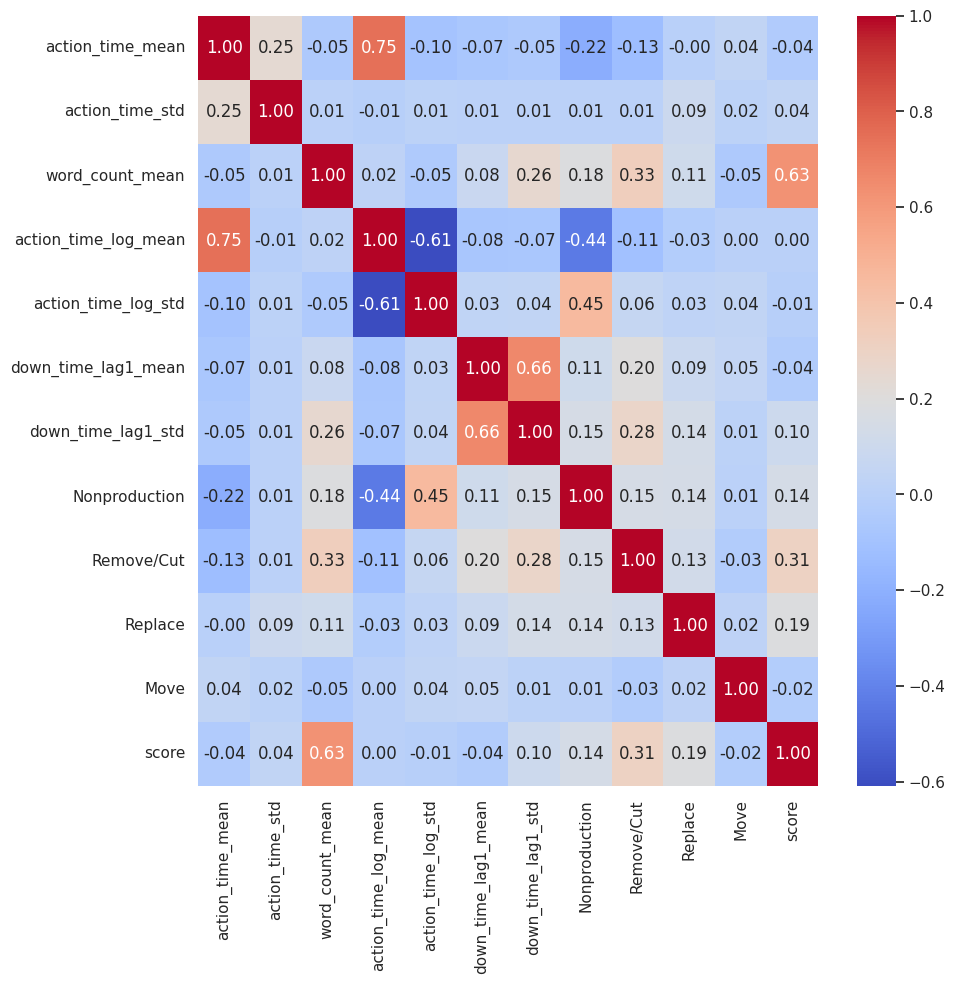

In [70]:
#проверка лин корреляции Пирсона
drop_col = ['id', 'y', 'Input', 'word_count_std']
correl = x_train_new_join_target.drop(drop_col, axis=1).corr()

sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(correl, annot=True, fmt=".2f", cmap= 'coolwarm');

In [71]:
x_train_new_join_target['y'].unique()

array([ 6,  3,  7,  8,  4,  9,  5, 10, 11,  1,  2,  0])

### для валидации
### for validation

In [72]:
x_valid_new = pipe_add.transform(x_valid)

x_valid_agg = df_agg(x_valid)

x_valid_agg_new = df_agg_activity(x_valid_agg, columns_activity)
x_valid_new_join = join_two_df(x_valid_new, x_valid_agg_new)

x_valid_new_join_target = join_w_target(x_valid_new_join, y_valid)

x_valid_new_join_target = add_klass(x_valid_new_join_target)
x_valid_new_join_target

,id,action_time_mean,action_time_std,word_count_mean,word_count_std,action_time_log_mean,action_time_log_std,down_time_lag1_mean,down_time_lag1_std,Nonproduction,Input,Remove/Cut,Replace,Move,score,y
0,0022f953,112.221271,55.431189,182.714751,97.763090,4.516625,0.993812,5.181264e+05,384246.602200,254,1938,260,1,0,3.5,6
1,0042269b,101.837766,82.383766,194.772727,108.935068,4.502382,0.600137,8.284960e+05,489509.081188,175,3515,439,7,0,6.0,11
2,00e1f05a,93.343215,198.896690,364.352159,207.108617,4.276279,0.820115,8.843470e+05,493334.430015,228,6145,1446,7,0,4.5,8
3,00f0737e,131.157285,81.291786,119.692053,79.707921,4.306283,1.643927,6.035255e+05,401132.188564,398,1780,237,1,0,2.5,4
4,00f8e84c,82.430529,43.591846,281.274389,168.116243,3.947912,1.501683,9.508620e+05,462081.502552,477,3182,62,0,0,4.5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,ff9a11ae,115.759066,91.889604,170.935989,93.444698,4.591669,0.720316,8.843147e+05,479816.825275,120,2773,741,6,0,3.5,6
491,ff9d1032,76.438247,126.558610,171.576965,96.281595,4.116985,0.698452,7.448387e+05,408608.725563,98,2296,366,1,0,4.0,7
492,ffab2ba4,63.867066,69.863913,165.328336,92.144748,4.095248,0.376152,6.152696e+05,379305.941674,70,1828,103,0,0,3.5,6
493,ffb8c745,105.437856,63.622575,256.353661,118.093794,4.473816,0.928110,7.360779e+05,503834.583587,189,3588,960,2,0,3.5,6


## Models

### RandomForestClassifier

In [73]:
def objective(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 20, 200),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
            'max_depth': trial.suggest_int('max_depth', 2, 100),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }

    clf = RandomForestClassifier(random_state=STATE, **params)

    x_train = x_train_new_join_target[x_train_new_join_target.columns[1:-2]]
    y_train = x_train_new_join_target['y']

    x_valid = x_valid_new_join_target[x_valid_new_join_target.columns[1:-2]]
    y_valid = x_valid_new_join_target['score']

    clf.fit(x_train, y_train)

    pred = (clf.predict(x_valid) + 1) / 2

    mse = mean_squared_error(y_valid, pred, squared=False)

    #return clf.score(x_valid, y_valid)
    return mse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2023-11-08 08:34:01,897] A new study created in memory with name: no-name-74704615-2651-4dee-a3e2-57c73f9b4768
[I 2023-11-08 08:34:03,202] Trial 0 finished with value: 0.8034018580103892 and parameters: {'n_estimators': 127, 'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8034018580103892.
[I 2023-11-08 08:34:04,145] Trial 1 finished with value: 0.8027729719194864 and parameters: {'n_estimators': 170, 'criterion': 'gini', 'max_depth': 59, 'min_samples_split': 14, 'min_samples_leaf': 15}. Best is trial 1 with value: 0.8027729719194864.
[I 2023-11-08 08:34:05,275] Trial 2 finished with value: 0.7859241488062113 and parameters: {'n_estimators': 166, 'criterion': 'gini', 'max_depth': 59, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7859241488062113.
[I 2023-11-08 08:34:07,233] Trial 3 finished with value: 0.7878496498108447 and parameters: {'n_estimators': 192, 'criterion': 'log_loss'

In [74]:
print("Best trial:", study.best_trial.number)
print("Best accuracy:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)


Best trial: 15
Best accuracy: 0.7836717515270115
Best hyperparameters: {'n_estimators': 89, 'criterion': 'entropy', 'max_depth': 42, 'min_samples_split': 4, 'min_samples_leaf': 1}


### RandomForestRegressor

In [75]:
def objective(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 20, 200),
            'criterion': trial.suggest_categorical('criterion', ['squared_error']),
            'max_depth': trial.suggest_int('max_depth', 2, 100),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }

    clf = RandomForestRegressor(random_state=STATE, **params)

    drop_col = ['id', 'y', 'Input', 'word_count_std', 'score']

    x_train = x_train_new_join_target.drop(drop_col, axis=1)
    y_train = x_train_new_join_target['score']

    x_valid = x_valid_new_join_target.drop(drop_col, axis=1)
    y_valid = x_valid_new_join_target['score']

    clf.fit(x_train, y_train)

    pred = clf.predict(x_valid)
    mse = mean_squared_error(y_valid, pred, squared=False)

    return mse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2023-11-08 08:34:22,297] A new study created in memory with name: no-name-49ed9fe8-4e2a-4802-818f-204cbdce6631
[I 2023-11-08 08:34:22,791] Trial 0 finished with value: 0.7440265100936537 and parameters: {'n_estimators': 54, 'criterion': 'squared_error', 'max_depth': 47, 'min_samples_split': 14, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.7440265100936537.
[I 2023-11-08 08:34:23,065] Trial 1 finished with value: 0.7474415809059735 and parameters: {'n_estimators': 29, 'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7440265100936537.
[I 2023-11-08 08:34:24,757] Trial 2 finished with value: 0.7489083268326651 and parameters: {'n_estimators': 190, 'criterion': 'squared_error', 'max_depth': 68, 'min_samples_split': 20, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.7440265100936537.
[I 2023-11-08 08:34:25,779] Trial 3 finished with value: 0.7483158625739206 and parameters: {'n_estimators': 88

In [76]:
print("Best trial:", study.best_trial.number)
print("Best accuracy:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)


Best trial: 12
Best accuracy: 0.7431773165408467
Best hyperparameters: {'n_estimators': 62, 'criterion': 'squared_error', 'max_depth': 42, 'min_samples_split': 13, 'min_samples_leaf': 11}


In [77]:
params = {'n_estimators': 107, 'criterion': 'squared_error', 'max_depth': 95, 'min_samples_split': 10, 'min_samples_leaf': 8}
rf = RandomForestRegressor(random_state=STATE, **params)

drop_col = ['id', 'y', 'Input', 'word_count_std', 'score']

x_train = x_train_new_join_target.drop(drop_col, axis=1)
y_train = x_train_new_join_target['score']

rf.fit(x_train, y_train)


RandomForestRegressor(max_depth=95, min_samples_leaf=8, min_samples_split=10,
                      n_estimators=107, random_state=33443)

### LinearRegression

In [78]:
lr = LinearRegression()

In [79]:
drop_col = ['id', 'y', 'Input', 'word_count_std', 'score']

x_train = x_train_new_join_target.drop(drop_col, axis=1)
y_train = x_train_new_join_target['score']

x_valid = x_valid_new_join_target.drop(drop_col, axis=1)
y_valid = x_valid_new_join_target['score']


In [80]:
lr.fit(x_train, y_train)

LinearRegression()

In [81]:
lr_pred = lr.predict(x_valid)

In [82]:
mean_squared_error(y_valid, np.round(lr_pred, 2), squared=False)

0.8193902635743264

In [83]:
lr_pred

array([3.63711161, 3.80137541, 5.34891504, 3.15519952, 4.03308608,
       3.95417475, 2.77325277, 3.62307726, 3.35389197, 3.56829193,
       4.15084113, 5.47069863, 3.94247474, 4.42320837, 2.84652236,
       4.53302677, 2.83982317, 3.80610113, 4.00776672, 3.2389075 ,
       4.04636962, 2.79739901, 3.52869882, 3.3764181 , 3.03739791,
       4.02657528, 2.95696151, 3.68694484, 3.85696426, 3.48342311,
       3.64748485, 4.3079778 , 3.06111311, 4.11443816, 4.42826236,
       3.55245753, 4.03521818, 3.38569516, 3.79588644, 4.74847294,
       3.58443577, 4.77296507, 3.43142852, 3.24154816, 4.24708145,
       3.28271053, 2.98196676, 3.15260576, 3.54705579, 3.71533108,
       4.30733736, 3.94886486, 4.06611771, 2.9502124 , 5.42895447,
       3.19392752, 4.04174597, 3.17260829, 3.1964358 , 3.21630845,
       4.35625632, 4.0001854 , 3.60812252, 3.31282603, 5.45272606,
       3.77944535, 3.81888454, 4.59233238, 4.31638291, 4.44119665,
       3.26070539, 3.45522942, 0.57740945, 3.63709333, 3.50636

In [84]:
np.round(lr_pred, 1)

array([3.6, 3.8, 5.3, 3.2, 4. , 4. , 2.8, 3.6, 3.4, 3.6, 4.2, 5.5, 3.9,
       4.4, 2.8, 4.5, 2.8, 3.8, 4. , 3.2, 4. , 2.8, 3.5, 3.4, 3. , 4. ,
       3. , 3.7, 3.9, 3.5, 3.6, 4.3, 3.1, 4.1, 4.4, 3.6, 4. , 3.4, 3.8,
       4.7, 3.6, 4.8, 3.4, 3.2, 4.2, 3.3, 3. , 3.2, 3.5, 3.7, 4.3, 3.9,
       4.1, 3. , 5.4, 3.2, 4. , 3.2, 3.2, 3.2, 4.4, 4. , 3.6, 3.3, 5.5,
       3.8, 3.8, 4.6, 4.3, 4.4, 3.3, 3.5, 0.6, 3.6, 3.5, 4. , 3.9, 2.8,
       4. , 3.5, 4.1, 3.3, 4. , 3.2, 3.9, 3.3, 3.4, 4.2, 3.5, 3.3, 3.6,
       4. , 3.2, 3. , 3.5, 3.5, 4. , 3.9, 3.9, 2.8, 2.8, 3.1, 3.6, 2.8,
       4. , 3.2, 3.3, 3.4, 4.1, 3.2, 3.3, 4.1, 3.7, 3.4, 4.2, 3.9, 3.5,
       5.3, 3.9, 3.5, 2.8, 2.8, 4.6, 4.1, 5.1, 3.7, 3.8, 2.9, 3.3, 3.4,
       3.8, 4.3, 3.9, 2.9, 4.7, 3.3, 3.7, 3.2, 3.3, 4.1, 4.3, 3. , 3. ,
       3.2, 3.4, 3.8, 3.8, 2.8, 2.8, 4.5, 3.7, 2.8, 5. , 4.5, 3.4, 3.8,
       4.4, 3.5, 3.4, 4.3, 3.4, 3.6, 3.5, 3.6, 4.2, 3.4, 3. , 3.5, 3.5,
       4.2, 6.1, 3.4, 4. , 4. , 3. , 3.3, 4. , 4. , 3. , 3. , 3.

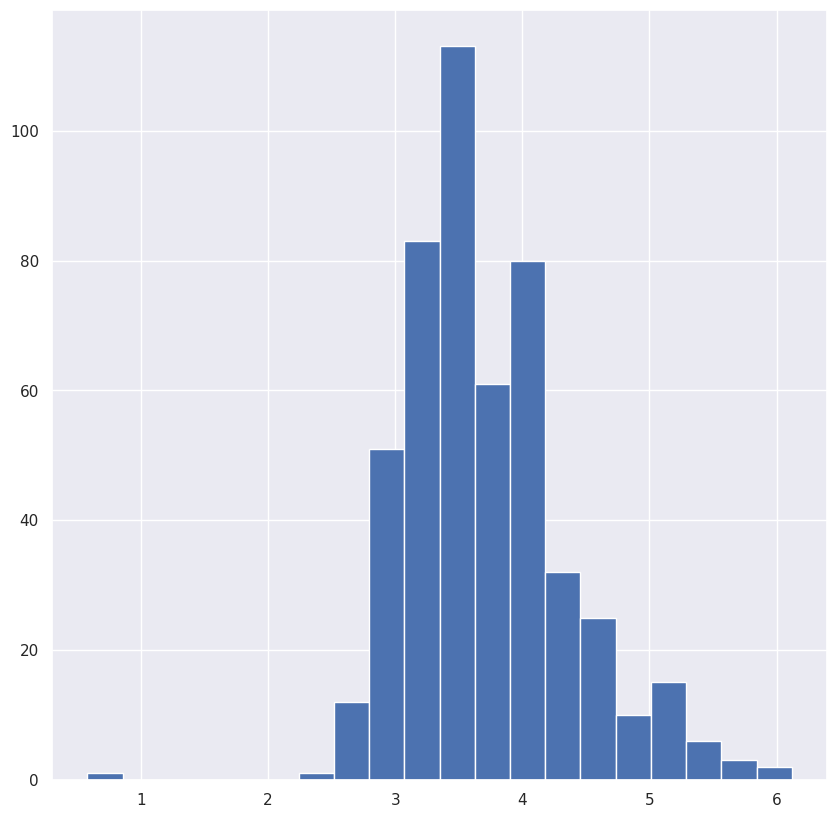

In [85]:
pd.Series(lr_pred).hist(bins=20);

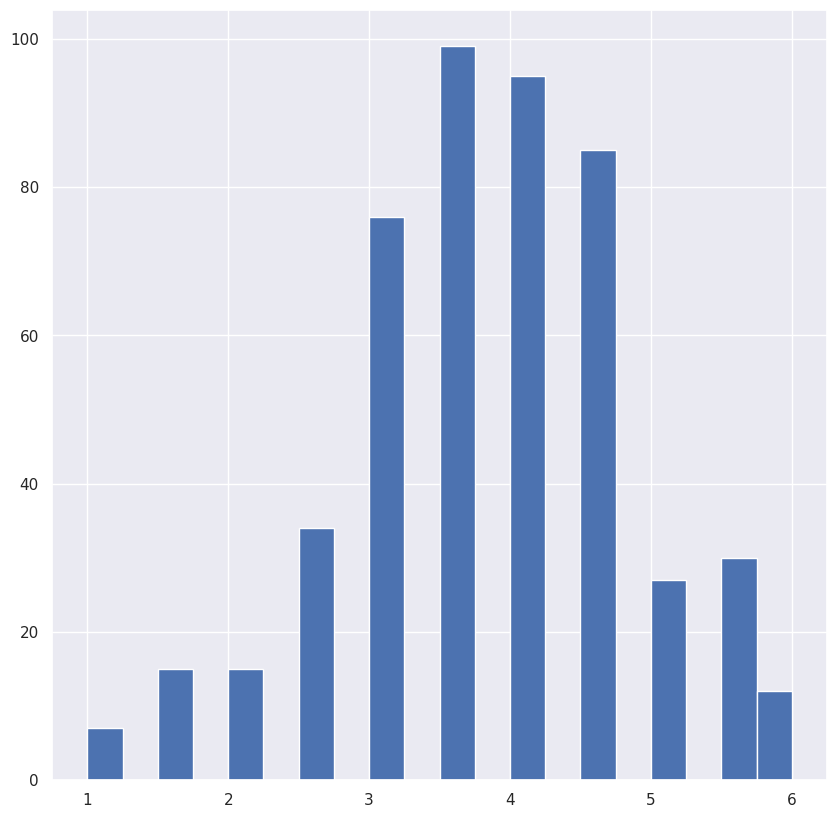

In [86]:
y_valid.hist(bins=20);

### CatBoost

### TEST

In [87]:
test_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [88]:
x_train

,action_time_mean,action_time_std,word_count_mean,action_time_log_mean,action_time_log_std,down_time_lag1_mean,down_time_lag1_std,Nonproduction,Remove/Cut,Replace,Move
0,116.246774,91.797374,128.116152,4.599037,0.731816,8.474761e+05,395017.895651,120,417,7,3
1,121.848329,113.768226,103.618895,4.112479,1.670000,7.857385e+05,385747.129680,99,151,1,0
2,123.943896,62.082013,125.082971,4.631532,0.835734,7.132523e+05,405370.160405,72,517,0,0
3,81.404342,40.653054,132.942560,4.324892,0.491386,5.442865e+05,484522.665101,76,338,3,0
4,109.717847,37.018331,119.671388,4.617338,0.585590,3.543206e+05,242084.043765,34,148,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1971,95.689408,45.091107,227.251047,4.424712,0.726349,6.793416e+05,459931.674935,67,468,0,0
1972,129.262599,37.822211,137.294430,4.765415,0.704039,2.340180e+05,109375.567726,43,112,1,0
1973,82.266129,36.178818,223.013057,4.239485,0.923658,8.419172e+05,512659.285164,148,60,1,0
1974,89.277915,54.515788,205.917027,4.339672,0.739735,5.766082e+05,334766.796220,71,276,0,0


In [89]:
x_test_new = pipe_add.transform(test_logs)

x_test_agg = df_agg(test_logs)

x_test_agg_new = df_agg_activity(x_test_agg, columns_activity)
x_test_new_join = join_two_df(x_test_new, x_test_agg_new)
x_test_new_join = x_test_new_join.drop(['id', 'word_count_std', 'Input'], axis=1)
x_test_new_join
#x_test_new_join_target = join_w_target(x_test_new_join, y_valid)

#x_test_new_join_target = add_klass(x_test_new_join_target)
#x_test_new_join_target

,action_time_mean,action_time_std,word_count_mean,action_time_log_mean,action_time_log_std,down_time_lag1_mean,down_time_lag1_std,Nonproduction,Remove/Cut,Replace,Move
0,86.0,1.414214,0.0,4.465842,0.016256,169216.5,239308.269277,0,0,0,0
1,56.5,14.849242,1.0,4.034828,0.261177,736014.5,34023.856990,0,0,0,0
2,75.0,26.870058,0.5,4.298464,0.361208,463024.5,243983.659315,0,0,0,0


In [90]:
pred = rf.predict(x_test_new_join)
pred

array([1.45628002, 1.59114143, 1.48904987])

### OUT file

In [91]:
sample_submission

,id,score
0,0000aaaa,1.0
1,2222bbbb,2.0
2,4444cccc,3.0


In [92]:
submission = sample_submission
submission['score']=pred
submission.to_csv("submission.csv", index=False)
submission

,id,score
0,0000aaaa,1.456280
1,2222bbbb,1.591141
2,4444cccc,1.489050


My score in this competition:

Public Score
0.714

Best Score
0.714 V2